In [1]:
# Librerías para la importación de archivos
import pandas as pd
import numpy as np

# Liberías para el tratamiento de los datos
import feature_engine
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.encoding import RareLabelEncoder, MeanEncoder
from feature_engine.outliers import Winsorizer, ArbitraryOutlierCapper, OutlierTrimmer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from funpymodeling.exploratory import freq_tbl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from skopt.space import Real, Integer, Categorical



# Liberías para graficos
import seaborn as sns
import matplotlib.pyplot  as plt



In [2]:

#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Codigo para poder imprimir multiples outputs en una misma línea
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#Seteo para que no utilice notacion cientifica
pd.options.display.float_format = '{:.2f}'.format

In [4]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selecciona features por su nombre. Servirá para aplicar pipelines a distintos datasets
    """
    def __init__(self, columns):
        """columns = lista de column names"""
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.columns]

## Transformacion de datos

#### Para la transformacion de datos implementare un pipeline de preprocesamiento luego de hacer una separacion en un Test/Train Split.

In [137]:
# Importo el dataset 
data_1 = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

In [138]:
# Elimino columnas que no usare
data_1 = data_1.drop(['created_on','currency','start_date','l1','end_date','title','description','operation_type'], axis=1)
data_1.head()

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,-34.61,-58.38,Capital Federal,San Cristobal,7.00,7.00,2.00,140.00,140.00,153000.00,Departamento
1,-34.62,-58.41,Capital Federal,Boedo,2.00,1.00,2.00,70.00,58.00,159000.00,PH
2,-34.59,-58.43,Capital Federal,Palermo,2.00,1.00,1.00,45.00,45.00,125000.00,PH
3,-34.58,-58.44,Capital Federal,Palermo,2.00,1.00,1.00,85.00,50.00,295000.00,PH
4,-34.91,-57.94,Bs.As. G.B.A. Zona Sur,La Plata,2.00,1.00,1.00,50.00,35.00,40000.00,PH


In [139]:
data_1.shape

(146660, 11)

#### Realizo un filtro por propiedades de Capital Federal y que sean Departamentos, PHs y Casas para que la comparacion con el modelo del Sprint 1 sea valida.

In [311]:
# Filtro por propiedades de Cap Fed y que sean Departamentos, PH y Casa
data_1 = data_1[data_1.property_type.isin(['Departamento', 'PH', 'Casa']) & (data_1.l2=='Capital Federal')]

#### Chequeo como queda distribuido el Dataset luego del primer filtro.

In [146]:
per = [0.01,0.02,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.98,0.99]
data_1.describe(percentiles=per)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,86951.00,86937.00,91485.00,91485.00,89314.00,82568.00,82250.00,91485.00
mean,-34.60,-58.44,2.96,1.96,1.56,112.63,94.97,259500.26
std,0.02,0.04,1.31,1.07,0.86,980.71,778.52,322265.44
min,-34.70,-58.53,1.00,0.00,1.00,10.00,1.00,6000.00
1%,-34.66,-58.52,1.00,0.00,1.00,26.00,25.00,58000.00
2%,-34.65,-58.51,1.00,0.00,1.00,30.00,27.00,65000.00
5%,-34.64,-58.50,1.00,1.00,1.00,34.00,32.00,78771.20
10%,-34.63,-58.49,2.00,1.00,1.00,39.00,36.00,90000.00
25%,-34.61,-58.46,2.00,1.00,1.00,49.00,44.00,120000.00
50%,-34.60,-58.43,3.00,2.00,1.00,71.00,63.00,175000.00


#### Dado que el 95% de las propiedades tienen un precio menor a USD695.000.- realizo un filtro en ese percentil, ya que cuando implemente el Pipeline el precio quedara en el conjunto 'Y' y no sera modificado. 

In [312]:
# Elimino prop con precio mayor a 695k
data_1 = data_1[data_1.price <= 695000]

In [313]:
# Chequeo cuantas filas quedaron.
data_1.shape

(86953, 11)

In [207]:
# Chequeo que columnas tienen valores faltantes y cuantos son
print('Valores faltantes por columnas')
data_1.isnull().sum()

Valores faltantes por columnas


lat                3931
lon                3945
l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms          2131
surface_total      8670
surface_covered    8972
price                 0
property_type         0
dtype: int64

<Figure size 1440x1080 with 0 Axes>

Text(0.5, 0.98, 'Boxplot de las variables: Ambientes, habitaciones, baños, superficie total, superficie cubierta, precio')

<AxesSubplot:>

<AxesSubplot:xlabel='rooms'>

Text(0.5, 0, 'Ambientes')

<AxesSubplot:>

<AxesSubplot:xlabel='bedrooms'>

Text(0.5, 0, 'Habitaciones')

<AxesSubplot:>

<AxesSubplot:xlabel='bathrooms'>

Text(0.5, 0, 'Baños')

<AxesSubplot:>

<AxesSubplot:xlabel='surface_total'>

Text(0.5, 0, 'Superficie total')

<AxesSubplot:>

<AxesSubplot:xlabel='surface_covered'>

Text(0.5, 0, 'Superficie Cubierta')

<AxesSubplot:>

<AxesSubplot:xlabel='price'>

Text(0.5, 0, 'Precio')

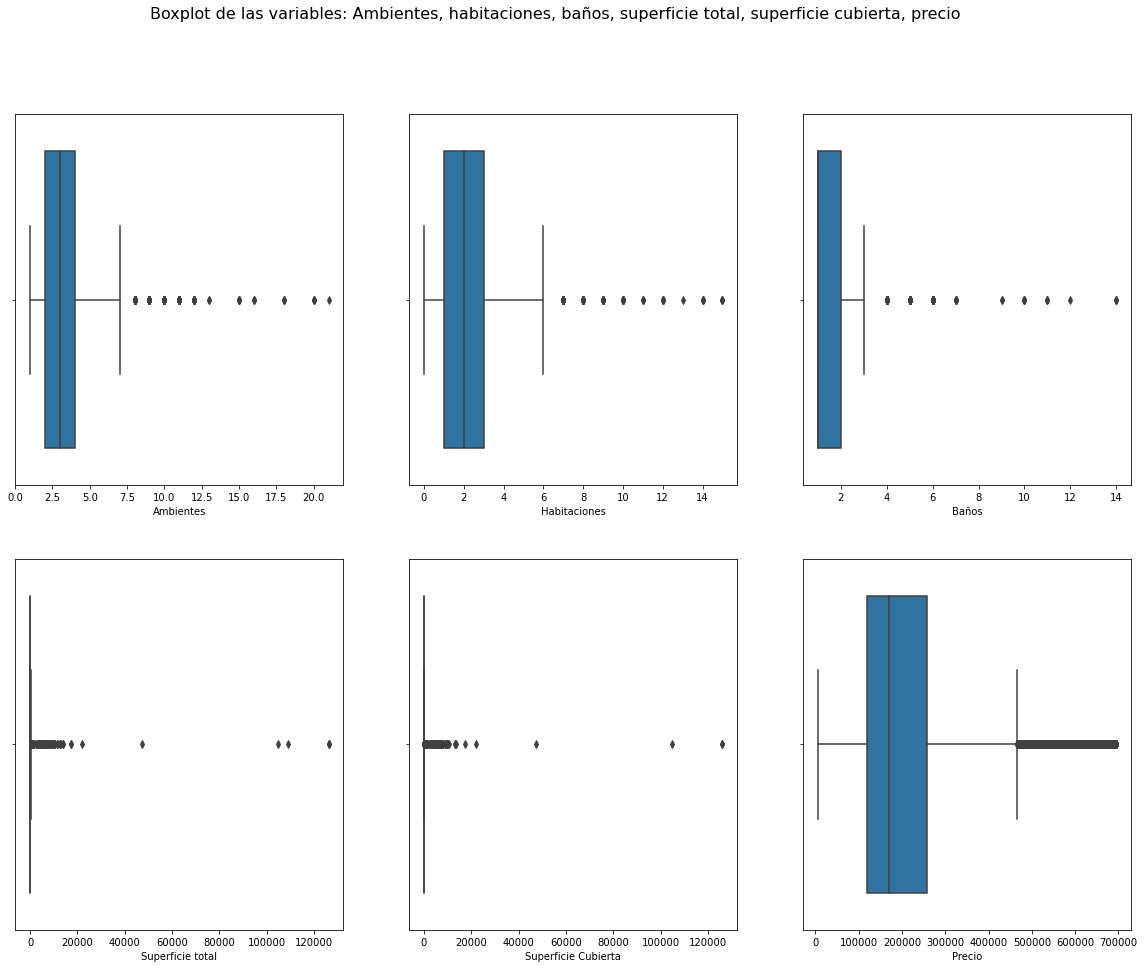

In [226]:
# Realizo un boxplot para identificar posibles outliers
plt.figure(figsize= (20,15))
plt.suptitle("Boxplot de las variables: Ambientes, habitaciones, baños, superficie total, superficie cubierta, precio", weight=16, size = 16)

plt.subplot(2,3,1)
sns.boxplot(data_1.rooms)
plt.xlabel('Ambientes')

plt.subplot(2,3,2)
sns.boxplot(data_1.bedrooms)
plt.xlabel('Habitaciones')

plt.subplot(2,3,3)
sns.boxplot(data_1.bathrooms)
plt.xlabel('Baños')

plt.subplot(2,3,4)
sns.boxplot(data_1.surface_total)
plt.xlabel('Superficie total')

plt.subplot(2,3,5)
sns.boxplot(data_1.surface_covered)
plt.xlabel('Superficie Cubierta')

plt.subplot(2,3,6)
sns.boxplot(data_1.price)
plt.xlabel('Precio')

In [224]:
# Realizo un describe para ver la distribucion de las variables pre Train/Test split
per = [0.01,0.02,0.03, 0.05, 0.1,0.25,0.5,0.75,0.9,0.95,0.98,0.99]
data_1.describe(percentiles = per)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,83022.00,83008.00,86953.00,86953.00,84822.00,78283.00,77981.00,86953.00
mean,-34.60,-58.44,2.87,1.89,1.47,103.77,86.89,206239.28
std,0.02,0.04,1.22,1.03,0.74,1004.56,796.87,122516.93
min,-34.70,-58.53,1.00,0.00,1.00,10.00,1.00,6000.00
1%,-34.66,-58.52,1.00,0.00,1.00,26.00,24.00,57552.00
2%,-34.65,-58.51,1.00,0.00,1.00,30.00,27.00,65000.00
3%,-34.64,-58.51,1.00,1.00,1.00,31.00,30.00,70000.00
5%,-34.64,-58.50,1.00,1.00,1.00,34.00,32.00,78000.00
10%,-34.63,-58.49,1.00,1.00,1.00,38.00,35.00,89900.00
25%,-34.61,-58.46,2.00,1.00,1.00,48.00,44.00,120000.00


Para la eliminacion de outliers decido utilizar el percentil 2 y 98, quedandome con el 96% de los datos. 

#### Para la transformacion de datos primeramente imputaré los valores que faltan, luego haré un 'encoding' de las variables categoricas y por ultimo eliminare los outliers. En este caso no usare un escalado de datos ya que no es necesario (seria necesario si estuviera usando un modelo de vecinos mas cercanos) ni generare variables nuevas ya que las existentes son suficientes para el modelo que implementaré.



## Realizo un test/train split para implementar el Pipeline

In [150]:
X_train, X_test, y_train, y_test = train_test_split(
            data_1.drop(['price'], axis=1),
            data_1['price'], test_size=0.3, random_state=0)
X_train.shape
X_test.shape
y_train.shape
y_test.shape

#X_train

(60867, 10)

(26086, 10)

(60867,)

(26086,)

#### Valores faltantes de X_train

In [151]:
# Mostramos los valores faltantes de X_train que seran reemplazados luego del pipeline
print('Latitud:', X_train['lat'].isnull().sum())
print('Longitud:', X_train['lon'].isnull().sum())
print('Baños:', X_train['bathrooms'].isnull().sum())
print('Baños:', X_train['surface_total'].isnull().sum())
print('Baños:', X_train['surface_covered'].isnull().sum())

Latitud: 2725
Longitud: 2732
Baños: 1513
Baños: 6094
Baños: 6291


In [22]:
# Chequeo que el formato de cada variable sea el que corresponda
X_train.dtypes

lat                float64
lon                float64
l2                  object
l3                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
property_type       object
dtype: object

## Pipeline de preprocesamiento
* ###  Tratamiento de variables numericas
    1. Metodo para imputar missings: mediante el MeanMedianImputer de la libreria FeatureEngine imputamos la mediana en las variables 'lat', 'lon','bathrooms','surface_total', y 'surface_covered'. 
* ###  Tratamiento de variables categoricas
    1. Metodo para convertir en numericas las variables categoricas: mediante el MeanEncoder de la libreria FeatureEngine imputamos el promedio por grupo (barrio, zona y tipo de propiedad) en las variables categoricas 'l2', 'l3' y 'property_type'.
* ###  Eliminacion de outliers pos imputacion de missings y encoding 
    1. Metodo para eliminar outliers en variables numericas (ya no hay variables categoricas): eliminamos outliers en percentiles 2 y 98. La eliminacion no ocurre borrando las filas sino reemplazando el valor por el valor tope establecido (capping).

## Pipeline

In [152]:
# Tomamos una lista con los atributos del dataframe X. Será útil para el pipel
featnames=list(X_train.columns)

# Creamos pipeline de preprocesamiento
pipe = Pipeline([
    # Selecciona todas las columnas disponibles en el dataframe de train
    ('selector', FeatureSelector(columns=featnames))
    
    # Numerical Treatment
    ,('median_imputer', MeanMedianImputer(imputation_method='median', variables=['lat', 'lon','bathrooms','surface_total','surface_covered'])) # Reemplaza missings por la mediana de la variable
      
    # Categorical Treatment
    ,('mean_encoder', MeanEncoder(variables=['l2','l3','property_type']) ) # Metodo para imputar el promedio en las variables categoricas l2 y l3 
      
    # Outlier removal
    ,('winsorizer', Winsorizer(capping_method='quantiles', tail='both', fold=0.02, missing_values='raise' )) # eliminamos outliers en los percentiles 2 y 98
    #,('capper', ArbitraryOutlierCapper(max_capping_dict={'surface_total': 500}, min_capping_dict={'surface_total': 27}, missing_values = 'raise'))
    #,('trimmer', OutlierTrimmer(capping_method='quantiles', tail='both', fold=0.02))
                                 
    #,('correlated_treatment', DropCorrelatedFeatures(method='pearson', threshold=0.8)) # Quita variables que tengan una correlación mayor a 0.8 (dropea el primer correlacionado que encuentra)
    #,('resampling', 'passthrough') # colocamos espacio para método de resampling, si fuera necesario (útil para problemas de clasificacion con clases desbalanceadas)
    
    # Nothing
    #,('nada','passthrough') # Para que el resampling no quede último ingresamos un step inútil
])

In [153]:
# Fiteamos el pipeline a los datos X e Y que tenemos en train (es decir, la clase ya sabrá que pasos seguir para imputar los missings, pero aún no lo ejecutará)
pipe_fitted = pipe.fit(X_train, y_train)

In [154]:
# Transformamos los X_train y X_test con los missings ya imputados, las variables encodeadas y los outliers removidos.
X_train_transformado = pipe_fitted.transform(X_train)
X_test_transformado = pipe_fitted.transform(X_test)


In [155]:
# Chequeamos los maximos y minimos de cada variable en la eliminacion de outliers.
pipe['winsorizer'].right_tail_caps_
pipe['winsorizer'].left_tail_caps_

{'lat': -34.551015,
 'lon': -58.3720736164,
 'l2': 206720.67594920073,
 'l3': 292176.0846473029,
 'rooms': 6.0,
 'bedrooms': 4.0,
 'bathrooms': 3.0,
 'surface_total': 270.0,
 'surface_covered': 200.0,
 'property_type': 331379.07839616993}

{'lat': -34.648100799999995,
 'lon': -58.51402368,
 'l2': 206720.67594920073,
 'l3': 120042.07439613529,
 'rooms': 1.0,
 'bedrooms': 0.0,
 'bathrooms': 1.0,
 'surface_total': 30.0,
 'surface_covered': 28.0,
 'property_type': 201422.90723519638}

In [156]:
# Verificamos que no haya valores faltantes en el conjunto de train ni de test
print('Valores faltantes en conjunto X_train_transformado')
print(X_train_transformado.isna().sum())
print('')
print('Valores faltantes en conjunto X_test_transformado')
print(X_test_transformado.isna().sum())

Valores faltantes en conjunto X_train_transformado
lat                0
lon                0
l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_type      0
dtype: int64

Valores faltantes en conjunto X_test_transformado
lat                0
lon                0
l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_type      0
dtype: int64


In [157]:
# Chequeamos que valor imputo en cada variable que contenia missings
pipe['median_imputer'].imputer_dict_

{'lat': -34.600156,
 'lon': -58.4344515126,
 'bathrooms': 1.0,
 'surface_total': 68.0,
 'surface_covered': 60.0}

In [158]:
# Chequeamos el encodeo que realizo a la variable 'L2', 'L3'(barrio) y 'property_type'
pipe['mean_encoder'].encoder_dict_

{'l2': {'Capital Federal': 206720.67594920073},
 'l3': {'Abasto': 173169.23262839878,
  'Agronomía': 181934.98979591837,
  'Almagro': 178763.5663448798,
  'Balvanera': 141387.1580756014,
  'Barracas': 205756.0036900369,
  'Barrio Norte': 254037.2793907663,
  'Belgrano': 278961.10351244477,
  'Boca': 116125.1287553648,
  'Boedo': 154568.61868300152,
  'Caballito': 207948.85883668903,
  'Catalinas': 206666.66666666666,
  'Centro / Microcentro': 146852.1857142857,
  'Chacarita': 174300.25800376647,
  'Coghlan': 211303.47073170732,
  'Colegiales': 206281.33603603602,
  'Congreso': 145327.34115138592,
  'Constitución': 102401.33633633633,
  'Flores': 177270.09249858995,
  'Floresta': 153322.5244648318,
  'Las Cañitas': 334886.55531914893,
  'Liniers': 160613.80359612725,
  'Mataderos': 173356.24807692308,
  'Monserrat': 139942.24329159214,
  'Monte Castro': 147694.9840909091,
  'Nuñez': 248956.24747081712,
  'Once': 148242.36170212767,
  'Palermo': 245562.3422720624,
  'Parque Avellaneda': 

In [159]:
# Verificamos que se hayan encodeado las variables categoricas en X_train y X_test
print('Zona y barrio encodeado en X_train_transformado')
print(X_train_transformado[['l2','l3','property_type']])
print('')
print('Zona y barrio encodeado en X_test_transformado')
print(X_test_transformado[['l2','l3','property_type']])

Zona y barrio encodeado en X_train_transformado
              l2        l3  property_type
77260  206720.68 120042.07      201422.91
56569  206720.68 245562.34      201422.91
30842  206720.68 207948.86      201422.91
66477  206720.68 120042.07      201422.91
24229  206720.68 178763.57      201422.91
...          ...       ...            ...
33828  206720.68 207948.86      201422.91
74351  206720.68 145327.34      201422.91
69058  206720.68 254037.28      201422.91
70547  206720.68 200249.47      201422.91
112494 206720.68 160613.80      201422.91

[60867 rows x 3 columns]

Zona y barrio encodeado en X_test_transformado
              l2        l3  property_type
29571  206720.68 178763.57      201422.91
47444  206720.68 207948.86      201422.91
67460  206720.68 245562.34      201422.91
109970 206720.68 245562.34      201422.91
71160  206720.68 278961.10      201422.91
...          ...       ...            ...
97771  206720.68 211303.47      201422.91
10476  206720.68 180914.53      201422

In [160]:
# Chequeo el shape de los conjuntos, no deberia haber cambiado por la eliminacion de outliers 
# ya que las filas con outliers no son removidas, sino que donde se encuentra el outlier 
# se reemplaza por el valor maximo admitido en el Pipeline.
print('Conjuntos X sin transformar')
print('Shape de X_train:', X_train.shape)
print('Shape de X_test:', X_test.shape)

print('')
print('Conjuntos X transformados')
print('Shape de X_train transformado:',X_train_transformado.shape)
print('Shape de X_test transformado:',X_test_transformado.shape)

Conjuntos X sin transformar
Shape de X_train: (60867, 10)
Shape de X_test: (26086, 10)

Conjuntos X transformados
Shape de X_train transformado: (60867, 10)
Shape de X_test transformado: (26086, 10)


In [161]:
# Realizamos un describe de X_train y X_train transformado para chequear que los outliers fueron reemplazados.
X_train.describe()
X_train_transformado.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered
count,58142.00,58135.00,60867.00,60867.00,59354.00,54773.00,54576.00
mean,-34.60,-58.44,2.87,1.90,1.47,107.43,88.96
std,0.02,0.04,1.23,1.04,0.74,1186.83,937.72
min,-34.70,-58.53,1.00,0.00,1.00,10.00,1.00
25%,-34.61,-58.46,2.00,1.00,1.00,48.00,44.00
50%,-34.60,-58.43,3.00,2.00,1.00,68.00,60.00
75%,-34.59,-58.41,4.00,3.00,2.00,102.00,89.00
max,-34.54,-58.35,21.00,15.00,14.00,126062.00,126062.00


,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type
count,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00
mean,-34.60,-58.44,206720.68,205075.96,2.85,1.87,1.43,82.84,71.50,206720.68
std,0.02,0.03,0.00,48827.17,1.14,0.95,0.65,49.66,38.16,21500.56
min,-34.65,-58.51,206720.68,120042.07,1.00,0.00,1.00,30.00,28.00,201422.91
25%,-34.61,-58.46,206720.68,163540.34,2.00,1.00,1.00,50.00,45.00,201422.91
50%,-34.60,-58.43,206720.68,200651.38,3.00,2.00,1.00,68.00,60.00,201422.91
75%,-34.59,-58.41,206720.68,245562.34,4.00,3.00,2.00,97.00,84.00,201422.91
max,-34.55,-58.37,206720.68,292176.08,6.00,4.00,3.00,270.00,200.00,331379.08


### Concateno el conjunto X_train e y_train para ver las correlaciones

In [164]:
conjunto_train = pd.concat([X_train_transformado, y_train], axis=1)
conjunto_train.shape

(60867, 11)

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, 'lat'),
  Text(1.5, 0, 'lon'),
  Text(2.5, 0, 'l2'),
  Text(3.5, 0, 'l3'),
  Text(4.5, 0, 'rooms'),
  Text(5.5, 0, 'bedrooms'),
  Text(6.5, 0, 'bathrooms'),
  Text(7.5, 0, 'surface_total'),
  Text(8.5, 0, 'surface_covered'),
  Text(9.5, 0, 'property_type'),
  Text(10.5, 0, 'price')])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, 'lat'),
  Text(0, 1.5, 'lon'),
  Text(0, 2.5, 'l2'),
  Text(0, 3.5, 'l3'),
  Text(0, 4.5, 'rooms'),
  Text(0, 5.5, 'bedrooms'),
  Text(0, 6.5, 'bathrooms'),
  Text(0, 7.5, 'surface_total'),
  Text(0, 8.5, 'surface_covered'),
  Text(0, 9.5, 'property_type'),
  Text(0, 10.5, 'price')])

Text(0.5, 1.0, 'Heatmap de correlaciones conjunto Train')

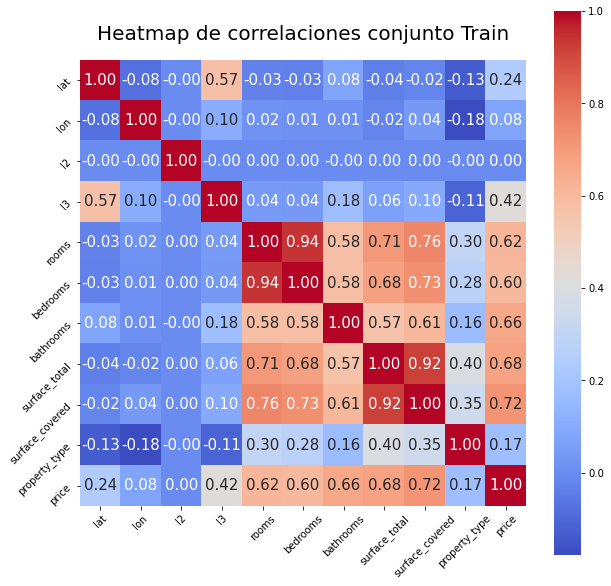

In [165]:
# Chequeo las correlaciones
corr = conjunto_train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title("Heatmap de correlaciones conjunto Train", size=20, pad=20)
plt.show()


A partir de analizar la tabla de correlaciones, se puede inferir que las mejores variables
para predecir el precio de una propiedad son la superficie total y cubierta, los baños y la cantidad de ambientes que posee.


In [166]:
conjunto_train.describe(percentiles = per)

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price
count,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00,60867.00
mean,-34.60,-58.44,206720.68,205075.96,2.85,1.87,1.43,82.84,71.50,206720.68,206720.68
std,0.02,0.03,0.00,48827.17,1.14,0.95,0.65,49.66,38.16,21500.56,123042.09
min,-34.65,-58.51,206720.68,120042.07,1.00,0.00,1.00,30.00,28.00,201422.91,6000.00
1%,-34.65,-58.51,206720.68,120042.07,1.00,0.00,1.00,30.00,28.00,201422.91,57000.00
2%,-34.65,-58.51,206720.68,120042.07,1.00,0.00,1.00,30.00,28.00,201422.91,65000.00
5%,-34.64,-58.50,206720.68,139942.24,1.00,1.00,1.00,34.00,32.00,201422.91,78000.00
10%,-34.63,-58.49,206720.68,146852.19,1.00,1.00,1.00,39.00,36.00,201422.91,90000.00
25%,-34.61,-58.46,206720.68,163540.34,2.00,1.00,1.00,50.00,45.00,201422.91,120000.00
50%,-34.60,-58.43,206720.68,200651.38,3.00,2.00,1.00,68.00,60.00,201422.91,170000.00


## Modelo Arbol de decision

Reentrenamiento del modelo Arbol de decision (modelo base), para hacer su posterior comparacion con el mismo modelo optimizado del Sprint 1.

DecisionTreeRegressor(max_depth=10, random_state=42)

Modelo: Arbol de decision
Raíz del error cuadrático medio en Train: 47086.81566698988
Raíz del error cuadrático medio en Test: 51552.136697071604
R2 en Train: 0.853546973059287
R2 Test: 0.8193039946931586


<Figure size 1008x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribucion de los errores')

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

Text(0.5, 0, 'errores')

Text(0.5, 1.0, 'Y_predichos vs Y_reales')

Text(0.5, 0, 'y (test)')

Text(0, 0.5, 'y_pred (test)')

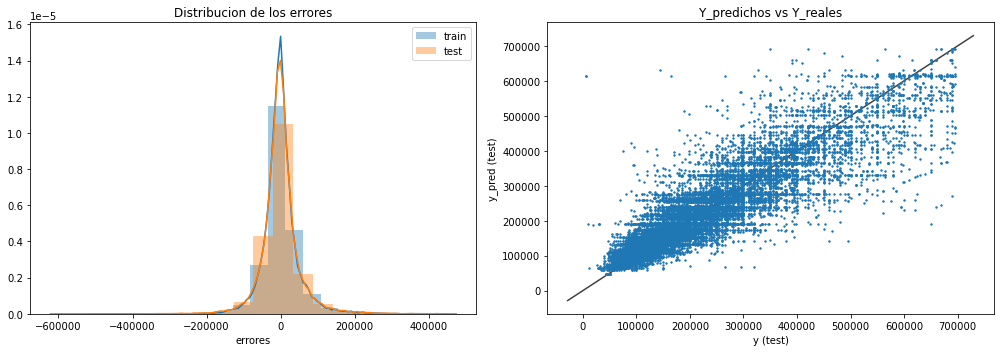

In [167]:
# Modelo arbol de decision

tree_regressor = DecisionTreeRegressor(max_depth=10, random_state=42)

# Entreno el modelo arboles de decision
tree_regressor.fit(X_train_transformado, y_train)

# Predecimos sobre nuestro set
y_train_pred_tree = tree_regressor.predict(X_train_transformado)
y_test_pred_tree = tree_regressor.predict(X_test_transformado)

# Buscamos RMSE y R2
rmse_tree_train = np.sqrt(mean_squared_error(y_train, y_train_pred_tree))
rmse_tree_test = np.sqrt(mean_squared_error(y_test, y_test_pred_tree))
r2_tree_train= r2_score(y_train, y_train_pred_tree)
r2_tree_test = r2_score(y_test, y_test_pred_tree)

# Imprimo resultados
print('Modelo: Arbol de decision')
print(f'Raíz del error cuadrático medio en Train: {rmse_tree_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_tree_test}')
print(f'R2 en Train: {r2_tree_train}')
print(f'R2 Test: {r2_tree_test}')

# Grafico
plt.figure(figsize = (14,5))

plt.subplot(1,2,1)
plt.title('Distribucion de los errores')
sns.distplot(y_train - y_train_pred_tree, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_tree, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
plt.title('Y_predichos vs Y_reales')
ax.scatter(y_test,y_test_pred_tree, s =2)
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()



In [233]:
resultados_tree = pd.DataFrame([[0.69,0.65,46148,48994],['0.85','0.82','47086','51552']], columns=['R2_train','R2_test','RMSE_Train','RMSE_Test']
                            ,index=['Decision_Tree_Sprint_1','Decision_Tree_Sprint_2'])

resultados_tree

,R2_train,R2_test,RMSE_Train,RMSE_Test
Decision_Tree_Sprint_1,0.69,0.65,46148,48994
Decision_Tree_Sprint_2,0.85,0.82,47086,51552


El arbol de decision entrenado en este Sprint presenta mejores resultados que los presentados en el Sprint 1. El R2 en test (la metrica que buscamos optimizar) mejora un 26%, pasando de 0.65 a 0.82. Esto se debe principalmente a un mejor preprocesamiento de los datos, especificamente el hecho de haber 'encodeado' las variables categoricas, pudiendo utilizar como variables predictoras la latitud y el barrio ('lat' y 'l3'). 
Si bien el RMSE del modelo del Sprint 2 aumento, esta metrica no es comparable debido a que en el Sprint 1 filtramos el dataset con un precio menor al filtrado en este Sprint.

## Modelos avanzados
Para los modelos avanzados decidi utilizar Random Forest y XGBoost.


### Random forest

In [234]:
#Entreno el modelo random forest por defecto
rf = RandomForestRegressor()
rf.fit(X_train_transformado,y_train)

RandomForestRegressor()

Modelo: Random Forest
Raíz del error cuadrático medio en Train: 15211.456089360227
Raíz del error cuadrático medio en Test: 36694.62086442799
R2 en Train: 0.9847158502011419
R2 Test: 0.9084496475367863


<Figure size 1008x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribucion de los errores')

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

Text(0.5, 0, 'errores')

Text(0.5, 1.0, 'Y_predichos vs Y_reales')

Text(0.5, 0, 'y (test)')

Text(0, 0.5, 'y_pred (test)')

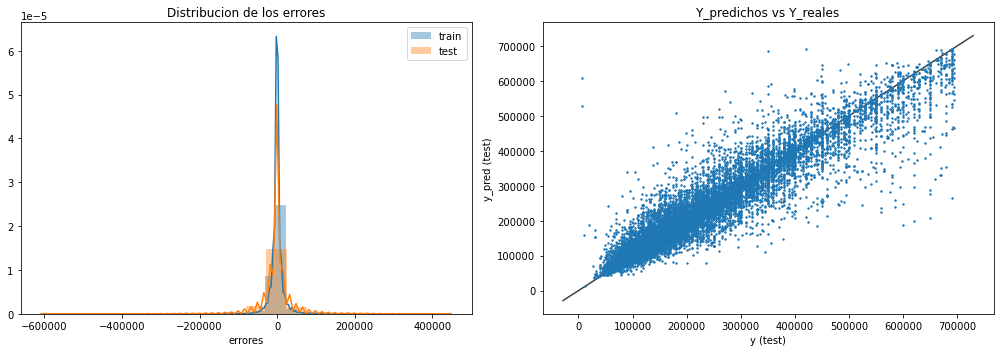

In [235]:
# Predecimos sobre nuestro set
y_train_pred_rf = rf.predict(X_train_transformado)
y_test_pred_rf = rf.predict(X_test_transformado)

# Buscamos RMSE y R2
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
r2_rf_train= r2_score(y_train, y_train_pred_rf)
r2_rf_test = r2_score(y_test, y_test_pred_rf)

# Imprimimos resultados
print('Modelo: Random Forest')
print(f'Raíz del error cuadrático medio en Train: {rmse_rf_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_rf_test}')
print(f'R2 en Train: {r2_rf_train}')
print(f'R2 Test: {r2_rf_test}')

# Graficamos los errores
plt.figure(figsize = (14,5))

plt.subplot(1,2,1)
plt.title('Distribucion de los errores')
sns.distplot(y_train - y_train_pred_rf, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_rf, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
plt.title('Y_predichos vs Y_reales')
ax.scatter(y_test,y_test_pred_rf, s =2)
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()



In [236]:
importances_rf = pd.DataFrame(np.transpose([X_train_transformado.columns, rf.feature_importances_]), columns = ['feature', 'importance']).sort_values(by='importance', ascending = False)

<Figure size 1080x432 with 0 Axes>

<AxesSubplot:xlabel='feature', ylabel='importance'>

Text(0.5, 1.0, 'Importancia de las variables')

Text(0, 0.5, 'Importancia')

Text(0.5, 0, 'Variable')

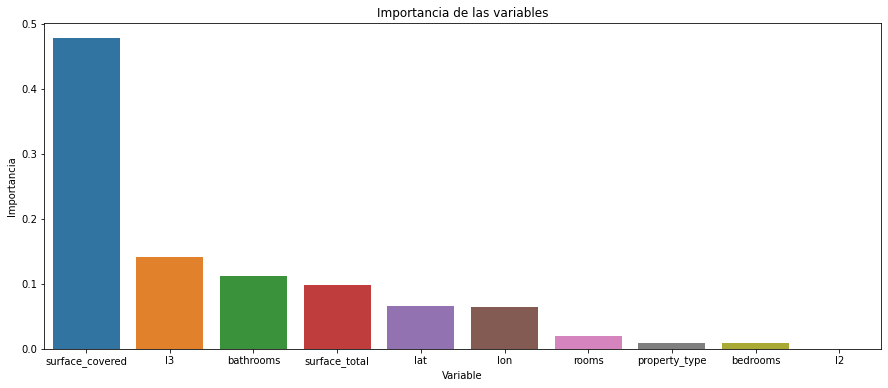

In [237]:
plt.figure(figsize = (15,6))
sns.barplot(data = importances_rf, x='feature', y='importance')
plt.title('Importancia de las variables')
plt.ylabel('Importancia')
plt.xlabel('Variable')
plt.show()

Este grafico nos muestra como la variable mas importante es la Superficie Cubierta, seguida por el Barrio en el que se encuentra la propiedad, la cantidad de Baños y la Superficie Total. 

#### Optimizacion Grid Search y Cross Validation para Random Forest

In [172]:
# Grilla para Randomized Search en Random Forest

n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1500 , num = 5)] # Cantidad de arboles.
max_features = ['auto'] # Cantidad de features a considerar en cada split.
max_depth = [int(x) for x in np.linspace(200, 800, num = 5)] # Max depth en cada arbol.
max_depth.append(None)
min_samples_split = [2,5,10] # Minima cantidad de samples requeridos para hacer el split en un nodo.
min_samples_leaf = [1,2,4] # Minima cantidad de samples requeridos en cada nodo de la hoja.
bootstrap = [True, False]

# Armo la random grid
random_grid = {'n_estimators' : n_estimators,
               'max_features' : max_features,
               'max_depth' : max_depth,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf' : min_samples_leaf,
               'bootstrap' : bootstrap}

print(random_grid)

rf = RandomForestRegressor()

# Armo el modelo

rf_randomgrid = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, random_state = 42, verbose= 10, n_jobs = -1)

# Fiteamos el modelo

rf_randomgrid.fit(X_train_transformado, y_train)

{'n_estimators': [300, 600, 900, 1200, 1500], 'max_features': ['auto'], 'max_depth': [200, 350, 500, 650, 800, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [200, 350, 500, 650, 800,
                                                      None],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300, 600, 900, 1200,
                                                         1500]},
                   random_state=42, verbose=10)

In [173]:
# Armamos un diccionario con los mejores hiperparametros encontrados por el modelo
rf_rg_best = rf_randomgrid.best_params_

# Metemos esos hiperparametros en nuestro modelo XGB
rf_randomgrid = rf.set_params(**rf_rg_best)

# Volvemos a entrenar el modelo
rf_randomgrid.fit(X_train_transformado, y_train)

RandomForestRegressor(n_estimators=1500)

Modelo: Random Forest optimizado con Random Search
Raíz del error cuadrático medio en Train: 14908.655855926434
Raíz del error cuadrático medio en Test: 36534.27681197602
R2 en Train: 0.9853182883933099
R2 Test: 0.9092479924513319


<Figure size 1008x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribucion de los errores')

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

Text(0.5, 0, 'errores')

Text(0.5, 1.0, 'Y_predichos vs Y_reales')

Text(0.5, 0, 'y (test)')

Text(0, 0.5, 'y_pred (test)')

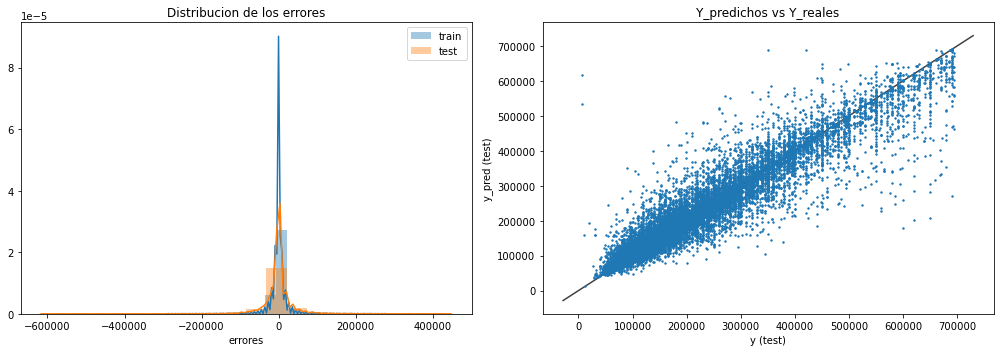

In [174]:
# Armo las predicciones
y_train_pred_rf_rgrid = rf_randomgrid.predict(X_train_transformado)
y_test_pred_rf_rgrid = rf_randomgrid.predict(X_test_transformado)

# Buscamos RMSE y R2
rmse_rf_train_rgrid = np.sqrt(mean_squared_error(y_train, y_train_pred_rf_rgrid))
rmse_rf_test_rgrid = np.sqrt(mean_squared_error(y_test, y_test_pred_rf_rgrid))
r2_rf_train_rgrid = r2_score(y_train, y_train_pred_rf_rgrid)
r2_rf_test_rgrid = r2_score(y_test, y_test_pred_rf_rgrid)

# Imprimo resultados
print('Modelo: Random Forest optimizado con Random Search')
print(f'Raíz del error cuadrático medio en Train: {rmse_rf_train_rgrid}')
print(f'Raíz del error cuadrático medio en Test: {rmse_rf_test_rgrid}')
print(f'R2 en Train: {r2_rf_train_rgrid}')
print(f'R2 Test: {r2_rf_test_rgrid}')

# Graficamos los errores
plt.figure(figsize = (14,5))

plt.subplot(1,2,1)
plt.title('Distribucion de los errores')
sns.distplot(y_train - y_train_pred_rf_rgrid, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_rf_rgrid, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
plt.title('Y_predichos vs Y_reales')
ax.scatter(y_test,y_test_pred_rf_rgrid, s =2)
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()



### XGBoost

In [238]:
import xgboost as xgb

In [239]:
# Entreno el modelo XGBoost
xgb_rf = xgb.XGBRegressor()
xgb_rf.fit(X_train_transformado, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Modelo: XGBoost
Raíz del error cuadrático medio en Train: 36492.62177187178
Raíz del error cuadrático medio en Test: 41973.546575378045
R2 en Train: 0.9120350133542421
R2 Test: 0.8802138671899405


<Figure size 1008x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribucion de los errores')

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

Text(0.5, 0, 'errores')

Text(0.5, 1.0, 'Y_predichos vs Y_reales')

Text(0.5, 0, 'y (test)')

Text(0, 0.5, 'y_pred (test)')

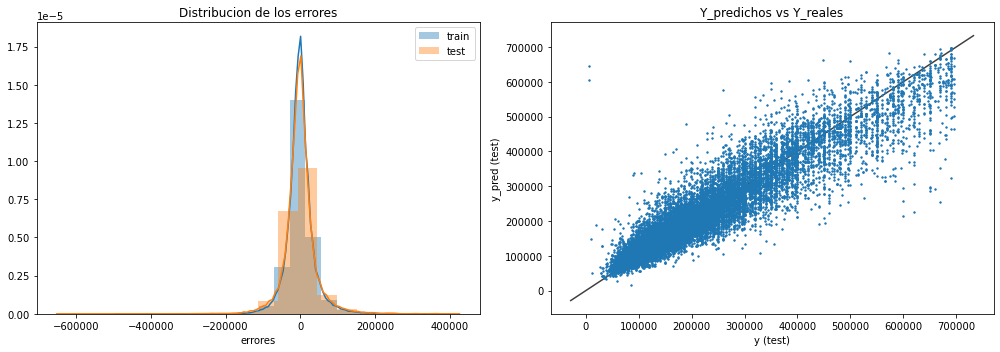

In [240]:
# Predecimos sobre nuestro set
y_train_pred_xgb = xgb_rf.predict(X_train_transformado)
y_test_pred_xgb = xgb_rf.predict(X_test_transformado)

# Buscamos RMSE y R2
rmse_xgb_train = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
rmse_xgb_test = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
r2_xgb_train= r2_score(y_train, y_train_pred_xgb)
r2_xgb_test = r2_score(y_test, y_test_pred_xgb)

# Imprimo resultados
print('Modelo: XGBoost')
print(f'Raíz del error cuadrático medio en Train: {rmse_xgb_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_xgb_test}')
print(f'R2 en Train: {r2_xgb_train}')
print(f'R2 Test: {r2_xgb_test}')

# Graficamos los errores
plt.figure(figsize = (14,5))

plt.subplot(1,2,1)
plt.title('Distribucion de los errores')
sns.distplot(y_train - y_train_pred_xgb, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_xgb, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
plt.title('Y_predichos vs Y_reales')
ax.scatter(y_test,y_test_pred_xgb, s =2)
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()



#### Optimizacion con Randomized Search y Cross Validation para XGBoost

In [271]:
# Armo la random grid
random_grid_xgb = {'max_depth' : [2,3,5,7],
               'learning_rate' : [0.01,0.1,0.2],
               'subsample' : np.arange(0.8, 1, 0.01),
               'colsample_bytree' : np.arange(0.7, 1, 0.01),
               'colsample_bylevel' : np.arange(0.5, 1, 0.1),
               'n_estimators' : [50,100,200,500,1000,1200]}

#print(random_grid)

xgb_opti = xgb.XGBRegressor()

# Armo el modelo

xgb_randomgrid = RandomizedSearchCV(estimator = xgb_opti, param_distributions = random_grid_xgb, scoring='neg_mean_squared_error', n_iter = 50, cv = 3, random_state = 42, n_jobs = -1, verbose=10)

# Fiteamos el modelo

xgb_randomgrid.fit(X_train_transformado, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
                                        'learning_rate

In [272]:
# Armamos un diccionario con los mejores hiperparametros encontrados por el modelo
xgboost_rg_best = xgb_randomgrid.best_params_

# Metemos esos hiperparametros en nuestro modelo XGB
xgb_randomgrid = xgb_opti.set_params(**xgboost_rg_best)

# Volvemos a entrenar el modelo
xgb_randomgrid.fit(X_train_transformado, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
             colsample_bynode=1, colsample_bytree=0.9700000000000002, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.9800000000000002, tree_method='exact',
             validate_parameters=1, verbosity=None)

Modelo: XGBoost optimizado con Random Search
Raíz del error cuadrático medio en Train: 20069.223510541102
Raíz del error cuadrático medio en Test: 35686.01010400033
R2 en Train: 0.9733951479130137
R2 Test: 0.913413297789693


<Figure size 1008x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribucion de los errores')

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

Text(0.5, 0, 'errores')

Text(0.5, 1.0, 'Y_predichos vs Y_reales')

Text(0.5, 0, 'y (test)')

Text(0, 0.5, 'y_pred (test)')

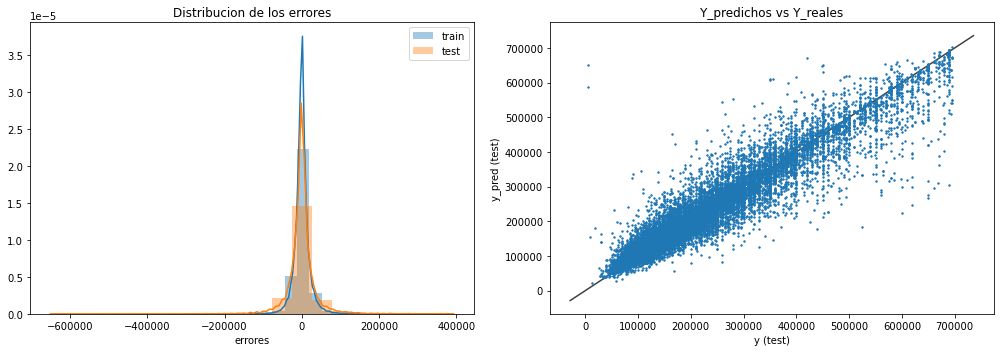

In [273]:
# Armo las predicciones
y_train_pred_xgb_rgrid = xgb_randomgrid.predict(X_train_transformado)
y_test_pred_xgb_rgrid = xgb_randomgrid.predict(X_test_transformado)

# Buscamos RMSE y R2
rmse_xgb_train_rgrid = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb_rgrid))
rmse_xgb_test_rgrid = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb_rgrid))
r2_xgb_train_rgrid = r2_score(y_train, y_train_pred_xgb_rgrid)
r2_xgb_test_rgrid = r2_score(y_test, y_test_pred_xgb_rgrid)

# Imprimo resultados
print('Modelo: XGBoost optimizado con Random Search')
print(f'Raíz del error cuadrático medio en Train: {rmse_xgb_train_rgrid}')
print(f'Raíz del error cuadrático medio en Test: {rmse_xgb_test_rgrid}')
print(f'R2 en Train: {r2_xgb_train_rgrid}')
print(f'R2 Test: {r2_xgb_test_rgrid}')

# Graficamos los errores
plt.figure(figsize = (14,5))

plt.subplot(1,2,1)
plt.title('Distribucion de los errores')
sns.distplot(y_train - y_train_pred_xgb_rgrid, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_xgb_rgrid, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
plt.title('Y_predichos vs Y_reales')
ax.scatter(y_test,y_test_pred_xgb_rgrid, s =2)
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()



#### Gp_minimize para XGBoost (utilizo Gp_minimize para probar otro metodo de optimizacion)

In [192]:
xgb_gp = xgb.XGBRegressor()

In [197]:
from skopt.space import Real, Integer, Categorical
# Definimos aquellos parámetros que queremos colocar, pero que queremos NO mover luego
FIXED_PARAMS = {         
                'random_state': 0,           
                     }

cant_columnas = X_train_transformado.shape[1]
space= [          
            Integer(2, 6, name='max_depth')
            ,Integer(50, 1500, name='n_estimators')
            ,Real(0.01, 0.5, name='learning_rate')
            ,Real(0.05, 1, name='colsample_bytree')
            ,Real(0.05, 0.1, name='colsample_bylevel') # mínima cantidad de registros para abrir una hoja
            ]
# listamos los nombres de los parámetros cuyo espacio de búsqueda acabamos de definir
param_names = ['max_depth','n_estimators','learning_rate','colsample_bytree','colsample_bylevel']

Definimos una funcion de métricas de evaluacion (para obtener RMSE)

In [198]:
from sklearn.metrics import roc_auc_score, mean_squared_error
def eval_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False) 
    return rmse

Lo más importante: definimos todo lo que es nuestra "función objetivo". Es decir, lo que queremos que se haga en cada iteración!

In [199]:
# 6) Definimos la funcion objetivo, que se utilizará a cada iteración de la búsqueda
# creamos una lista para guardar los resultados
lista_results = []
lista_test_scores_cv = []
lista_train_scores_cv = []
lista_test_std_cv = []
lista_test_r2 = []
lista_train_r2 = []

from skopt.utils import use_named_args
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

@use_named_args(space)
def objective(**params):

    # seteamos los parámetros fijos
    xgb_gp.set_params(**FIXED_PARAMS)
    # y los parámetros de cada iteración (se setearán automáticamente así)
    xgb_gp.set_params(**params)
    
    ####################################################################################
    ############################# USAMOS CROSS VALIDATION ##############################
    ####################################################################################
    # Ahora en vez de eso calculamos nuestros scores de test de un cross validation
    # Recordemos, este objeto devuelve un array de todos los test_scores y tambien de los train_scores hallados --> nuestra loss será el promedio de los test_scores
    model_i_scores = cross_validate(xgb_gp, X_train_transformado, y_train, cv=5, scoring=  make_scorer(eval_metrics), return_train_score=True)
    mean_test_scores = model_i_scores['test_score'].mean()
    # Peeero tambien nos guardamos los promedios de train para poder ver si en general se estuvo overfitteando o no 
    mean_train_scores = model_i_scores['train_score'].mean()
    # Por último, resulta interesante ver cuan volatil fueron esos test_scores. Así que tomamos su desvio standard (std)
    std_test_scores = model_i_scores['test_score'].std()
    
    
    # Calculamos el r2 de cada iteracion
    model_i_scores_r2 = cross_validate(xgb_gp, X_train_transformado, y_train, cv=5, scoring= 'r2', return_train_score=True)
    mean_test_scores_r2 = model_i_scores_r2['test_score'].mean()
    # Peeero tambien nos guardamos los promedios de train para poder ver si en general se estuvo overfitteando o no 
    mean_train_scores_r2 = model_i_scores_r2['train_score'].mean()
    
    
    
    # Ahora guardamos estos datos en las listas vacias que creamos antes, así nos quedan bien guardados
    lista_test_scores_cv.append(mean_test_scores) # test 
    lista_train_scores_cv.append(mean_train_scores) # train
    lista_test_std_cv.append(std_test_scores) # std de test
    
    lista_test_r2.append(mean_test_scores_r2) # sumo r2 promedios de cada iteracion en test
    lista_train_r2.append(mean_train_scores_r2) # sumo r2 promedio de cara iteracin en train
    
 
    # Definimos que la funcion de perdida sea el promedio de los scores de test
    loss = mean_test_scores
    ####################################################################################
    ####################################################################################
    ####################################################################################
    
    return loss 

In [200]:
# 7) Ejecutamos la búsqueda de los hiperparámetros 

from skopt import gp_minimize, forest_minimize, dump
# import joblib
from tqdm.notebook import tqdm

# Armamos una calse con tqdm para poder ver el progreso de la búsqueda
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
    def __call__(self, res):
        self._bar.update()
        
# Cantidad de iteraciones para la búsqueda (utilizar muchas, aqui usamos 50 solo por probar)
cantidad_iteraciones = 50

# Búsqueda
res = gp_minimize(
                    objective
                    ,space
                    ,n_calls = cantidad_iteraciones
                    ,n_initial_points = int(round(cantidad_iteraciones*0.2)) # Cantidad de iteraciones iniciales random (20% es significativo, pero dando mucho espacio para que el algoritmo optimice)
                    ,n_jobs=1
                    ,random_state = 0
                    ,verbose=1
                    ,callback=[tqdm_skopt(total=cantidad_iteraciones, desc="Gaussian Process")]
                    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 129.0650
Function value obtained: 44408.7565
Current minimum: 44408.7565
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 52.7130
Function value obtained: 53397.3128
Current minimum: 44408.7565
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 100.9067
Function value obtained: 44893.2791
Current minimum: 44408.7565
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 71.8722
Function value obtained: 55989.1061
Current minimum: 44408.7565
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 124.2323
Function value obtained: 44980.8439
Current minimum

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 173.8537
Function value obtained: 42277.8270
Current minimum: 42184.2744
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 174.3225
Function value obtained: 42296.4758
Current minimum: 42184.2744
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 174.6919
Function value obtained: 42352.5359
Current minimum: 42184.2744
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 174.6143
Function value obtained: 42382.9137
Current minimum: 42184.2744
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 175.1325
Function value obtained: 42338.8968
Current

In [201]:
res.x

[5, 1500, 0.433562930233844, 0.7945937952095075, 0.05]

In [202]:
df_vemos_que_paso = pd.DataFrame(res.x_iters)
df_vemos_que_paso.columns = param_names
df_vemos_que_paso['funcion_costo'] = res.func_vals
df_vemos_que_paso['numero_de_iteracion'] = df_vemos_que_paso.reset_index()['index']
df_vemos_que_paso['score_train'] = lista_train_scores_cv
df_vemos_que_paso['score_test'] = lista_test_scores_cv
df_vemos_que_paso['dif_train_test'] = df_vemos_que_paso['score_test'] - df_vemos_que_paso['score_train']
df_vemos_que_paso['std_test'] = lista_test_std_cv
df_vemos_que_paso['score_train_r2'] = lista_train_r2
df_vemos_que_paso['score_test_r2'] = lista_test_r2
df_vemos_que_paso.sort_values('funcion_costo', ascending=True, inplace=True)
df_vemos_que_paso

,max_depth,n_estimators,learning_rate,colsample_bytree,colsample_bylevel,funcion_costo,numero_de_iteracion,score_train,score_test,dif_train_test,std_test,score_train_r2,score_test_r2
33,5,1500,0.43,0.79,0.05,42184.27,33,30072.11,42184.27,12112.17,535.89,0.94,0.88
28,5,1500,0.43,0.80,0.05,42193.95,28,29952.48,42193.95,12241.46,515.36,0.94,0.88
32,5,1500,0.44,0.80,0.05,42247.09,32,29970.12,42247.09,12276.97,556.06,0.94,0.88
44,5,1500,0.44,0.80,0.05,42247.63,44,29950.81,42247.63,12296.82,698.57,0.94,0.88
20,5,1500,0.44,0.79,0.07,42265.04,20,29862.03,42265.04,12403.01,482.73,0.94,0.88
46,5,1500,0.44,0.79,0.05,42267.55,46,30079.69,42267.55,12187.86,603.30,0.94,0.88
39,5,1500,0.43,0.80,0.05,42277.83,39,30046.69,42277.83,12231.13,594.31,0.94,0.88
24,5,1500,0.43,0.80,0.05,42278.99,24,30035.39,42278.99,12243.60,474.55,0.94,0.88
35,5,1500,0.43,0.79,0.05,42286.40,35,29995.57,42286.40,12290.83,723.80,0.94,0.88
49,5,1500,0.44,0.80,0.05,42286.95,49,29879.08,42286.95,12407.87,483.62,0.94,0.88


#### Luego de ver los resultados e hiperparametros de los modelos pasados realizo un XGBoost optimizando manualmente para maximizar R2 en Test con la menor distancia posible de R2 en Train.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.1,
             colsample_bynode=1, colsample_bytree=0.64, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1200, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Modelo: XGBoost
Raíz del error cuadrático medio en Train: 33962.13473820299
Raíz del error cuadrático medio en Test: 40396.31659260141
R2 en Train: 0.9238114566144203
R2 Test: 0.8890470776855323


<Figure size 1008x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribucion de los errores')

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

<AxesSubplot:title={'center':'Distribucion de los errores'}, xlabel='price'>

Text(0.5, 0, 'errores')

Text(0.5, 1.0, 'Y_predichos vs Y_reales')

Text(0.5, 0, 'y (test)')

Text(0, 0.5, 'y_pred (test)')

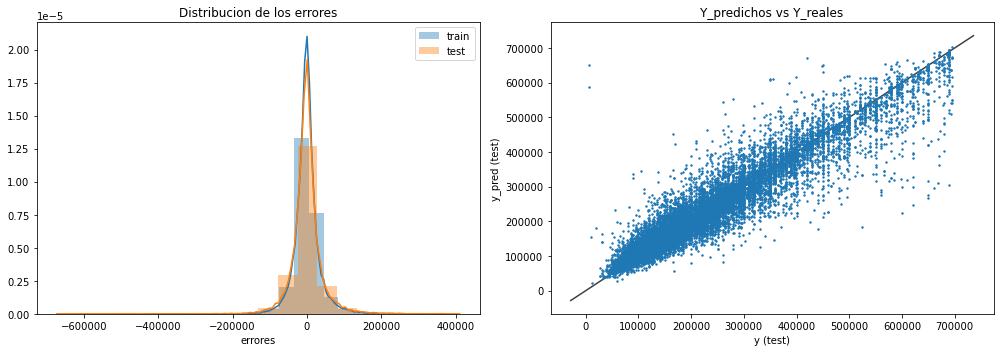

In [275]:

# Entreno el modelo XGBoost con optimizacion manual
xgb_man_opt = xgb.XGBRegressor(n_estimators=1200, max_depth=7, learning_rate=0.1, colsample_bytree=0.64, reg_lambda=1, colsample_bylevel=0.1, random_state=42)
xgb_man_opt.fit(X_train_transformado, y_train)

# Predecimos sobre nuestro set
y_train_pred_xgb_man_opt = xgb_man_opt.predict(X_train_transformado)
y_test_pred_xgb_man_opt = xgb_man_opt.predict(X_test_transformado)

# Buscamos RMSE y R2
rmse_xgb_man_opt_train = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb_man_opt))
rmse_xgb_man_opt_test = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb_man_opt))
r2_xgb_man_opt_train= r2_score(y_train, y_train_pred_xgb_man_opt)
r2_xgb_man_opt_test = r2_score(y_test, y_test_pred_xgb_man_opt)

# Imprimo resultados
print('Modelo: XGBoost')
print(f'Raíz del error cuadrático medio en Train: {rmse_xgb_gp_opt_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_xgb_gp_opt_test}')
print(f'R2 en Train: {r2_xgb_gp_opt_train}')
print(f'R2 Test: {r2_xgb_gp_opt_test}')

# Graficamos los errores
plt.figure(figsize = (14,5))

plt.subplot(1,2,1)
plt.title('Distribucion de los errores')
sns.distplot(y_train - y_train_pred_xgb_man_opt, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_xgb_man_opt, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
plt.title('Y_predichos vs Y_reales')
ax.scatter(y_test,y_test_pred_xgb_rgrid, s =2)
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

In [291]:
import shap

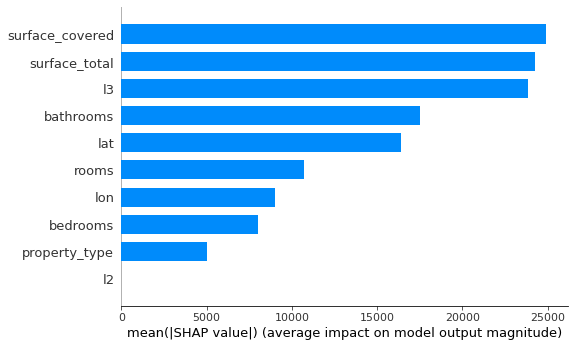

In [292]:
# Utilizamos el explicador de SHAP
shap_values = shap.TreeExplainer(xgb_man_opt).shap_values(X_train_transformado)
shap.summary_plot(shap_values, X_train_transformado, plot_type="bar")

## Comparacion de modelos

In [278]:
resultados = pd.DataFrame([[0.69,0.65,46148,48994],['0.85','0.82','47086','51552'],['0.98','0.91','15193','36696'],['0.98','0.91','14908','36534'],
                          ['0.91','0.88','36492','41973'],['0.97','0.91','20069','35686'],['0.94','0.88','30072','42184'],['0.92','0.89','33962','40396']], 
                            columns=['R2_train','R2_test','RMSE_Train','RMSE_Test']
                            ,index=['Decision_Tree_Sprint_1','Decision_tree_Sprint_2','Random_Forest','Random_Forest_RndmSearch_opt'
                            ,'XGBoost','XGBoost_RandmSearch_opt','XGBoost_GpMinimize_opt','XGBoost_Manual_opt'])
resultados

,R2_train,R2_test,RMSE_Train,RMSE_Test
Decision_Tree_Sprint_1,0.69,0.65,46148,48994
Decision_tree_Sprint_2,0.85,0.82,47086,51552
Random_Forest,0.98,0.91,15193,36696
Random_Forest_RndmSearch_opt,0.98,0.91,14908,36534
XGBoost,0.91,0.88,36492,41973
XGBoost_RandmSearch_opt,0.97,0.91,20069,35686
XGBoost_GpMinimize_opt,0.94,0.88,30072,42184
XGBoost_Manual_opt,0.92,0.89,33962,40396


#### Luego de entrenar y testear todos los modelos se pueden realizar algunas afirmaciones:
1. El arbol de decision del Sprint 2 mejora las metricas sensiblemente (R2 26% mejor) respecto del arbol de decision del Sprint 
2. Los modelos avanzados performan mucho mejor que los arboles de decision clasicos:

#### En los modelos avanzados hay una clara diferencia sobre cual es el mejor:
1. Si bien el Random Forest obtiene los mejores R2 en Train y Test, y los menores errores cuadraticos medios; tiende a hacer 'Overfitting', es decir, ajustarse a los datos de entrenamiento demasiado bien, para luego, cuando lleguen los datos de testeo, no performar de la mejor manera. La diferencia que se aprecia entre el R2 en Train y Test en ambos modelos (RF con hiperparametros por defectos y RF optimizado) es de 0.07 puntos; y la diferencia entre el RMSE de Train y Test es de USD21.500.- aproximadamente en ambos modelos.
    
2. En XGBoost probe diferentes optimizaciones hasta lograr, optimizando manualmente luego de ver los valores de las optimizaciones hechas, poder maximizar el R2 en Test minimizando su distancia con el R2 de Train. Asi, logre obtener un modelo (Xgb_manual_opt) con un RMSE en Train de USD33.963 y en Test de USD40.396 (solo USD6.434 de diferencia) y con un R2 en Train de 0.92 y en Test de 0.89 (solo 0.02 puntos inferior al modelo con mejor Score en Test: 0.91) pero mucho mas estable con ingresos de datos nuevos.
3. Para el modelo elegido, visualice las importancias de las variables con la libreria SHAP y se puede ver que las 3 variables que mas explican el precio son la superficie cubierta y total, y el barrio al cual pertence la propiedad, lo cual tiene todo el sentido ya que cuanto mas grande sea la propiedad y mas caro sea el precio por m2 en el barrio en el cual se encuentra la propiedad mas alto sera su precio final.

### Analisis de errores de 'Y' predichas por barrio

In [293]:
# Resto error de conjunto test (precios reales de propiedades) menos el conjunto predicho en test del RF sin opt
y_error = y_test - y_test_pred_xgb_man_opt

In [324]:
# Transformo en Dataframe
y_error = pd.DataFrame(y_error)

In [326]:
y_error.head()

,price_error
29571,17566.70
47444,-64756.75
67460,-529.86
109970,-22029.31
71160,24642.75


In [296]:
# Renombro la columna para que tenga nombre diferente del conjunto original
y_error = y_error.rename(columns={'price':'price_error'})


In [297]:
# Concateno el conjunto X_test_transformados (sin missings, encodeados y con outliers capeados) con los y_test (precios originales)
conjunto_test = pd.concat([X_test_transformado, y_test], axis=1)
conjunto_test.shape

(26086, 11)

In [298]:
# Concateno el conjunto test con el error de los Y
conjunto_test = pd.concat([conjunto_test, y_error], axis=1)
conjunto_test.shape


(26086, 12)

In [299]:
conjunto_test.head()

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price,price_error
29571,-34.60,-58.43,206720.68,178763.57,3.00,2.00,2.00,68.00,60.00,201422.91,235000.00,17566.70
47444,-34.62,-58.43,206720.68,207948.86,3.00,2.00,2.00,109.00,109.00,201422.91,230000.00,-64756.75
67460,-34.59,-58.43,206720.68,245562.34,3.00,2.00,1.00,63.00,55.00,201422.91,165000.00,-529.86
109970,-34.60,-58.42,206720.68,245562.34,2.00,1.00,1.00,48.00,45.00,201422.91,130000.00,-22029.31
71160,-34.56,-58.44,206720.68,278961.10,3.00,2.00,2.00,80.00,80.00,201422.91,335000.00,24642.75


In [300]:
# Calculo el promedio y la cantaidad de errores filtrando por barrio
error_barrio = conjunto_test.groupby('l3').agg({'price_error' : ['mean','count']})

In [301]:
# Convierto a DataFrame error_barrio
error_barrio = pd.DataFrame(error_barrio)

In [302]:
# Calculo el promedio y la cantidad de errores filtrando por tipo de propiedad
error_tipo_propiedad = conjunto_test.groupby('property_type').agg({'price_error' : ['mean','count']})

In [303]:
# Convierto a DataFrame error_tipo_propiedad
error_tipo_propiedad = pd.DataFrame(error_tipo_propiedad)

In [304]:
# Chequeo los categoricos encodeados 
pipe['mean_encoder'].encoder_dict_

{'l2': {'Capital Federal': 206720.67594920073},
 'l3': {'Abasto': 173169.23262839878,
  'Agronomía': 181934.98979591837,
  'Almagro': 178763.5663448798,
  'Balvanera': 141387.1580756014,
  'Barracas': 205756.0036900369,
  'Barrio Norte': 254037.2793907663,
  'Belgrano': 278961.10351244477,
  'Boca': 116125.1287553648,
  'Boedo': 154568.61868300152,
  'Caballito': 207948.85883668903,
  'Catalinas': 206666.66666666666,
  'Centro / Microcentro': 146852.1857142857,
  'Chacarita': 174300.25800376647,
  'Coghlan': 211303.47073170732,
  'Colegiales': 206281.33603603602,
  'Congreso': 145327.34115138592,
  'Constitución': 102401.33633633633,
  'Flores': 177270.09249858995,
  'Floresta': 153322.5244648318,
  'Las Cañitas': 334886.55531914893,
  'Liniers': 160613.80359612725,
  'Mataderos': 173356.24807692308,
  'Monserrat': 139942.24329159214,
  'Monte Castro': 147694.9840909091,
  'Nuñez': 248956.24747081712,
  'Once': 148242.36170212767,
  'Palermo': 245562.3422720624,
  'Parque Avellaneda': 

In [305]:
# Renombro las columnas
error_barrio.columns = ['mean','count']

In [314]:
error_barrio.sort_values(by = 'count', ascending = False)

,mean,count
l3,,
245562.34,-1011.84,3564
178763.57,375.53,2210
207948.86,-1290.95,2045
292176.08,308.30,1911
163540.34,151.53,1908
278961.10,-108.24,1868
200651.38,340.15,1017
254037.28,-712.10,920
141387.16,-360.65,898


Como era esperable, los barrios con mayor cantidad de errores en las predicciones son los barrios con mas cantidad de propiedades: Palermo, Almagro, Caballito y Recoleta.

Sin embargo, los barrios con un promedio mayor de error en las predicciones (promedio del precio real de las propiedades del barrio vs promedio del precio predicho de las propiedades) fueron Catalinas, Villa Ortuzar, San Nicolas y Parque Patricios.

### Conclusiones

En el proyecto del primer Sprint no teniamos todas las variables a disposicion y muchas contenian missings, por otro lado los modelos que utilizamos no eran lo suficientemente profundos. Todo eso generaba que el entrenamiento y testeo de esos modelos arrojaran metricas no muy buenas y modelos pocos estables.

Con las transformaciones implementadas a principio de este proyecto ya nos garantizamos un Dataset mucho mas robusto, lo cual queda evidenciado poniendo en practica el mismo Arbol de decision del proyecto pasado y obteniendo metricas mejores. Los dos modelos avanzados implementados y optimizados de la manera correcta logran que podamos encontrar un modelo que se ajuste lo mas posible a estos datos sin caer en Overfitting para que pueda ser confiable y estable en el tiempo con la ingesta de datos nuevos.

